In [1]:
import shutil

import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Jena Climate Exercise

## Step 1: Get the data

Use the `get_file` utitlity from keras to download the following file.

`URL = https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip`

In [2]:
path = tf.keras.utils.get_file(
  origin="https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip"
)
shutil.unpack_archive(path, extract_dir=".")

13565642/13565642 [==============================] - 1s 0us/step


In [3]:
df = pd.read_csv("jena_climate_2009_2016.csv")
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


Create two Numpy arrays.

- One for the temperature values called `temperature`
- One for all columns except the date but including the temperature, called `raw_data`



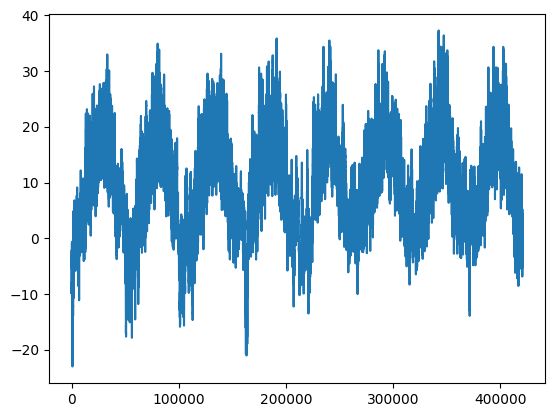

In [4]:
temperature = df['T (degC)'].values
raw_data = df.drop("Date Time", axis="columns").values
plt.plot(temperature);

## Step 2: Prepare the data

The problem we are trying to solve is: "given data covering the previous five days, and sampled once per hour, can we predict the temperature in 24 hours?"

As a first step, we are going to determine the number of rows to use for training, validating and testing. We will use a 50, 25, 25 split.

Next, we are going to normalize each feature independently using the mean and standard deviation calculated from the training examples.

In [5]:
num_train_samples = int(0.5 * raw_data.shape[0])
num_val_samples = int(0.25 * raw_data.shape[0])
num_test_samples = raw_data.shape[0] - num_train_samples - num_val_samples

In [6]:
mean = raw_data[:num_train_samples].mean(axis=0)
std = raw_data[:num_train_samples].std(axis=0)
raw_data = (raw_data - mean) / std

Use `timeseries_dataset_from_array` to create datasets that

- Sample every 6 samples (because we want data every hour)
- The sequences should have length 120 (because we want to use 5 days, i.e. 120 hours)
- The target should be delayed by $120 \times 6 + (24 - 1) \times 6$
- Use batches of size 256.
- Shuffle the training data, but not the validation nor the test data

Create a function `create_ds` that you call three times using the appropriate data.

In [7]:
def create_ds(raw_data, target, shuffle=True,batch_size=256):

    sampling_rate=6
    sequence_length=120
    delay=sampling_rate * (sequence_length + 24 -1)
    return tf.keras.utils.timeseries_dataset_from_array(
        data=raw_data,
        targets=target[delay:],
        sampling_rate=sampling_rate,
        sequence_length=sequence_length,
        shuffle=shuffle,
        batch_size=batch_size
    )

train_dataset = create_ds(raw_data[:num_train_samples],
                          target=temperature[:num_train_samples])
val_dataset = create_ds(raw_data[num_train_samples:num_train_samples+num_val_samples],
                          target=temperature[num_train_samples:num_train_samples+num_val_samples],
                          shuffle=False)
test_dataset = create_ds(raw_data[num_train_samples+num_val_samples:],
                          target=temperature[num_train_samples+num_val_samples:],
                          shuffle=False)

In [8]:
for samples, targets in train_dataset.take(1):
    print(f"samples shape: {samples.shape}")
    print(f"targets shape: {targets.shape}")

samples shape: (256, 120, 14)
targets shape: (256,)


In [ ]:
## Check correctness of the create_ds method by only using the data
my_check_ds = create_ds(
    raw_data=df.values[:1000,0],
    target=df.values[:1000,0],
    shuffle=False,
    batch_size=1
)

In [ ]:
for features, target in my_check_ds.take(2):
    print(f"{features} maps to {target}")
    print("*"*50)

## Step 3: Establish a common sense baseline

The most naive thing to do is to assume that the temperature 24 hours from now, will equal the current temperature.

Compute the MAE on the validation and test set. (You should get 2.44 and 2.62 respectively)

In [9]:
def compute_mae_naive(dataset):
    mean = temperature[:num_train_samples].mean()
    std = temperature[:num_train_samples].std()

    total_error = 0.0
    total_samples = 0
    for samples, target in dataset:
    # Get last time step, feature with index 1 is the temperature
        current_temperature = samples[:, -1, 1] * std + mean
        total_error += np.sum(np.abs(target - current_temperature))
        total_samples += samples.shape[0]

    return total_error / total_samples

print(f"MAE on validation data: {compute_mae_naive(val_dataset):.2f}")
print(f"MAE on test data: {compute_mae_naive(test_dataset):.2f}")

MAE on validation data: 2.44
MAE on test data: 2.62


## Step 4: Establish a non-sequence baseline

Create a simple feed-forward neural network consisting of one hidden layer of 16
neurons using the ReLu activation function, and one output layer. Both layers
are `Dense` layers.

- Use RMSProp as the optimizer (with the default learning rate), optimize the mean squared error, and track the mean absolute error as a metric.
- Use a callback to save the best model using `ModelCheckpoint`.
- Train for 10 epochs.
- Report the MAE on the test dataset

In [ ]:
train_dataset = train_dataset.cache().prefetch(1)
val_dataset = val_dataset.cache().prefetch(1)

tf.random.set_seed(42)
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=[120, raw_data.shape[-1]]),
    tf.keras.layers.Dense(units=16, activation='relu'),
    tf.keras.layers.Dense(units=1, activation=None)
])

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "jena_dense.keras",
    save_best_only=True
)

model.compile(
    optimizer="rmsprop",
    loss="mse",
    metrics=["mae"]
)

model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    callbacks=[model_checkpoint]
)

In [ ]:
model = tf.keras.models.load_model("jena_dense.keras")
model.evaluate(test_dataset)

In [ ]:
model.summary()

Note: this densely connected network doesn't perform better than the common sense baseline.



### Step 5: Use a `SimpleRNN`

In [ ]:
model_rnn = tf.keras.models.Sequential([
    tf.keras.layers.SimpleRNN(units=16, input_shape=(None, raw_data.shape[-1])),
    tf.keras.layers.Dense(units=1, activation=None)
])

model_checkpoint_rnn = tf.keras.callbacks.ModelCheckpoint(
    "jena_rnn.keras",
    save_best_only=True
)

model_rnn.summary()

In [ ]:
model_rnn.compile(
    optimizer="rmsprop",
    loss="mse",
    metrics=["mae"]
)

model_rnn.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    callbacks=[model_checkpoint_rnn]
)

In [ ]:
model_rnn = tf.keras.models.load_model("jena_rnn.keras")
model_rnn.evaluate(test_dataset)

In [ ]:
model_rnn.evaluate(val_dataset)

## Step 6: A single layer recurrent neural net using LSTM cell

---



- Create  a single layer of `LSTM` cells, where each LSTM cell has 16 units.
- Add a single `Dense` layer on top of the (last) LSTM in order to retrieve a single number as output.
- Optimize your model is the same way as the previous Dense network.




In [ ]:
model_lstm = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(units=16, input_shape=(None, raw_data.shape[-1])),
    tf.keras.layers.Dense(units=1, activation=None)
])

model_checkpoint_lstm = tf.keras.callbacks.ModelCheckpoint(
    "jena_lstm.keras",
    save_best_only=True
)

model_lstm.compile(
    optimizer="rmsprop",
    loss="mse",
    metrics=["mae"]
)

model_lstm.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    callbacks=[model_checkpoint_lstm]
)

model_lstm.summary()

In [ ]:
model_lstm = tf.keras.models.load_model("jena_lstm.keras")
model_lstm.evaluate(test_dataset)

In [ ]:
model_lstm.evaluate(val_dataset)

We barely beat the common sense baseline model.

## Step 7: Use recurrent dropout to fight overfitting

- Drop 25 percent of the hidden state between time steps using the `recurrent_dropout` parameter.
- Double the number of units in the LSTM cell to 32 (because we rely on the dropout to combat overfitting.)
- Apply 50 percent dropout to the final output of the recurrent layer (i.e. prior to feeding it to the `Dense` output layer).




In [ ]:
model_lstm_dropout = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(units=32, recurrent_dropout=0.25, input_shape=(None, raw_data.shape[-1])),
  tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(units=1, activation=None)
])

model_checkpoint_lstm_dropout = tf.keras.callbacks.ModelCheckpoint(
    "jena_lstm_dropout.keras",
    save_best_only=True
)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_mae",
    min_delta=0.001,
    patience=3
)

model_lstm_dropout.compile(
    optimizer="rmsprop",
    loss="mse",
    metrics=["mae"]
)

model_lstm_dropout.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    callbacks=[model_checkpoint_lstm, early_stopping_cb]
)

In [ ]:
model_lstm_dropout.evaluate(test_dataset)